In [1]:
import analysis
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as sg
import scipy.interpolate as interp
import seaborn as sns
import time
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from line_least_cost import llc

%matplotlib inline

#based on the following paper
#https://ws680.nist.gov/publication/get_pdf.cfm?pub_id=901379

In [2]:
data_path = 'SH_031_04192017_EDITS.txt'
meants_path = 'moion_meants.txt'

In [3]:
data = pd.read_csv(data_path, sep='\t|,', names=['Time', 'O2', 'CO2'],
                 usecols=['Time', 'O2', 'CO2'], index_col=False)[['Time', 'O2', 'CO2']]
filtered_O2 = analysis.fft_analysis().fourier_filter_no_resample(data.Time, data.O2, 3,100)
filtered_CO2 = analysis.fft_analysis().fourier_filter_no_resample(data.Time, data.CO2, 3,100)

meants = np.loadtxt(meants_path, delimiter='\n')
meants_ts = np.linspace(0,480,len(meants))
filtered_ts = np.linspace(0,480, len(data.O2))

if(data.Time[len(data.Time)-1] < 10):
    data.Time = data.Time * 60

/Users/borainbow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [4]:
def get_centroid(t_series, data_series):
    """
    centroid is a signal weighted average of time. We are essentially calculating the temporal middle of the signal
    
    t_series = time points of data_series
    data_series = the signal intensity series
    """
    #set buffer to 0
    buffer = 0.0 
    #pack t_series and d_series together and calculate square weighted sum
    for t, d in zip(t_series, data_series):
        buffer += (d**2) * t
    #return square weighted average
    return buffer/(np.sum(data_series**2))


#############################################
cent_meants = get_centroid(meants_ts, sg.savgol_filter(meants,21,3))
cent_meants_noFilter = get_centroid(meants_ts, meants)
cent_O2 = get_centroid(data.Time, sg.savgol_filter(filtered_O2,21,3))
cent_CO2 = get_centroid(data.Time, sg.savgol_filter(filtered_CO2,21,3))

print(cent_meants, cent_meants_noFilter)
        

240.7415802306184 240.60506041459325


In [5]:
#normalize data

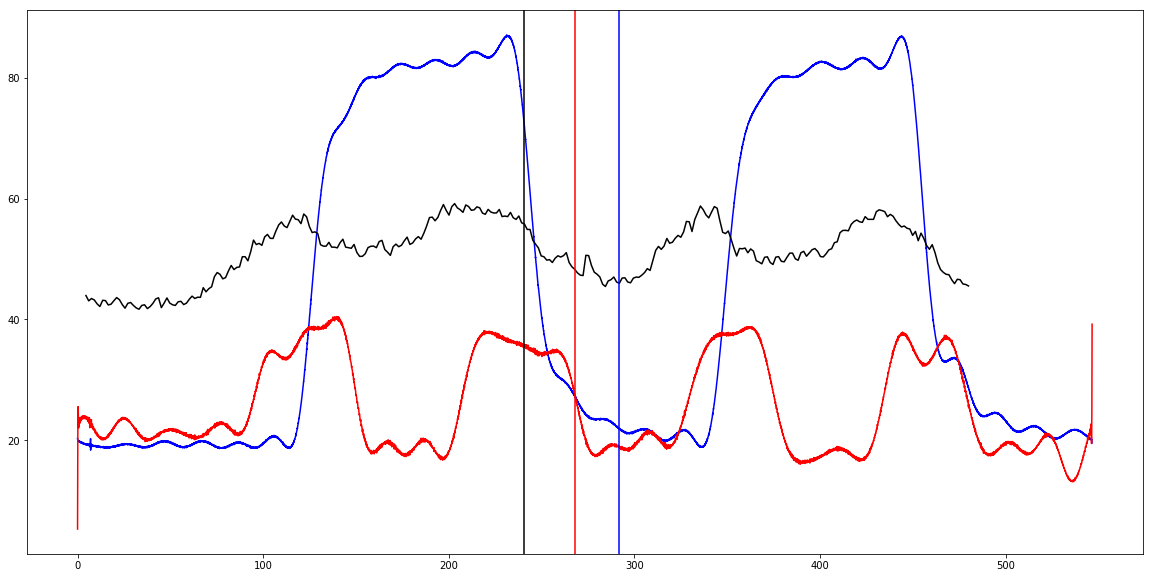

In [6]:
plt.figure(figsize=(20,10))
# plt.plot(filtered_ts, filtered_O2, color='blue')
# plt.plot(filtered_ts, filtered_CO2, color='red')

plt.plot(data.Time, filtered_O2, color='blue')
plt.plot(data.Time, sg.savgol_filter(filtered_CO2,25,3), color='red')
plt.plot(meants_ts[3:], meants[3:]-300, color='black') #shifted meants downwards
plt.axvline(x= cent_meants, color = 'black')
plt.axvline(x= cent_O2, color ='blue')
plt.axvline(x= cent_CO2, color='red')

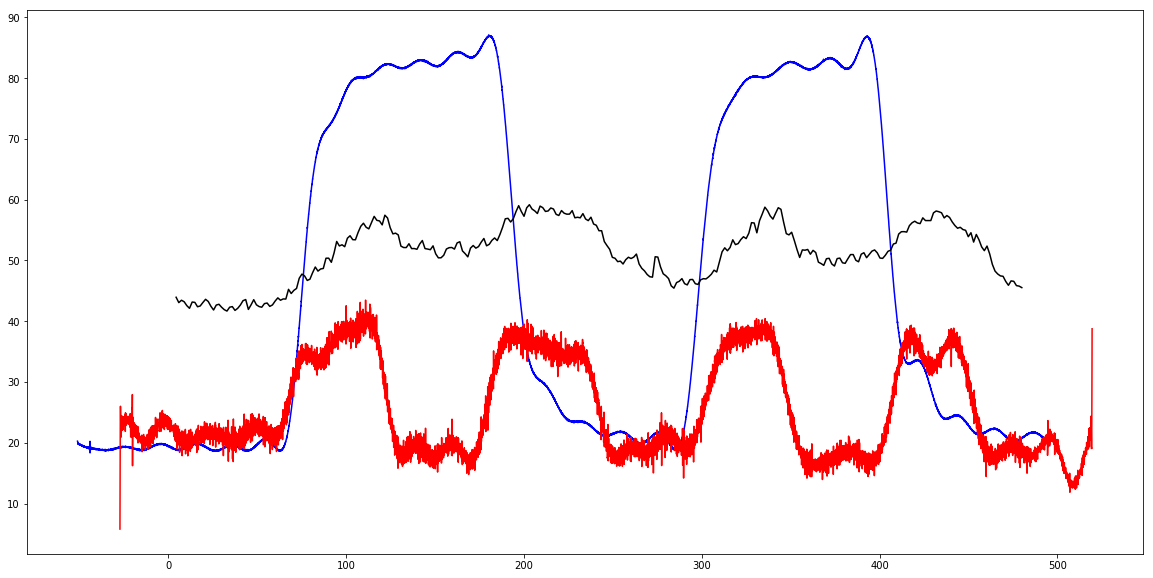

In [7]:
plt.figure(figsize=(20,10))
plt.plot(data.Time-(cent_O2 - cent_meants), filtered_O2, color='blue')
plt.plot(data.Time-(cent_CO2 - cent_meants), filtered_CO2, color='red')
plt.plot(meants_ts[3:], meants[3:]-300, color='black')

In [8]:
O2_resampler = interp.interp1d(data.Time-(cent_O2 - cent_meants), filtered_O2, fill_value = 'extrapolate')
CO2_resampler = interp.interp1d(data.Time-(cent_CO2 - cent_meants), filtered_CO2, fill_value= ' extrapolate')

O2_exact_aligned = O2_resampler(meants_ts)
CO2_exact_aligned = CO2_resampler(meants_ts)

In [9]:
#make review copies and normalize them
O2_exact_aligned_review = O2_exact_aligned.copy()[3:]
CO2_exact_aligned_review = CO2_exact_aligned.copy()[3:]
meants_review = meants.copy()[3:]

O2_exact_aligned_review -= O2_exact_aligned_review.mean()
CO2_exact_aligned_review -= CO2_exact_aligned_review.mean()
meants_review -= meants_review.mean()

O2_exact_aligned_review /= O2_exact_aligned_review.std()
CO2_exact_aligned_review /= CO2_exact_aligned_review.std()
meants_review /= meants_review.std()

In [10]:

#cut data to correct lenghts

# O2_exact_aligned = (O2_exact_aligned/np.max(O2_exact_aligned))[3:]
# CO2_exact_aligned = (CO2_exact_aligned/np.max(CO2_exact_aligned))[3:]
# meants =  meants[3:]-323
# meants_ts = meants_ts[3:]

O2_exact_aligned = O2_exact_aligned[3:]
CO2_exact_aligned = CO2_exact_aligned[3:]
meants =  meants[3:]-323
meants_ts = meants_ts[3:]

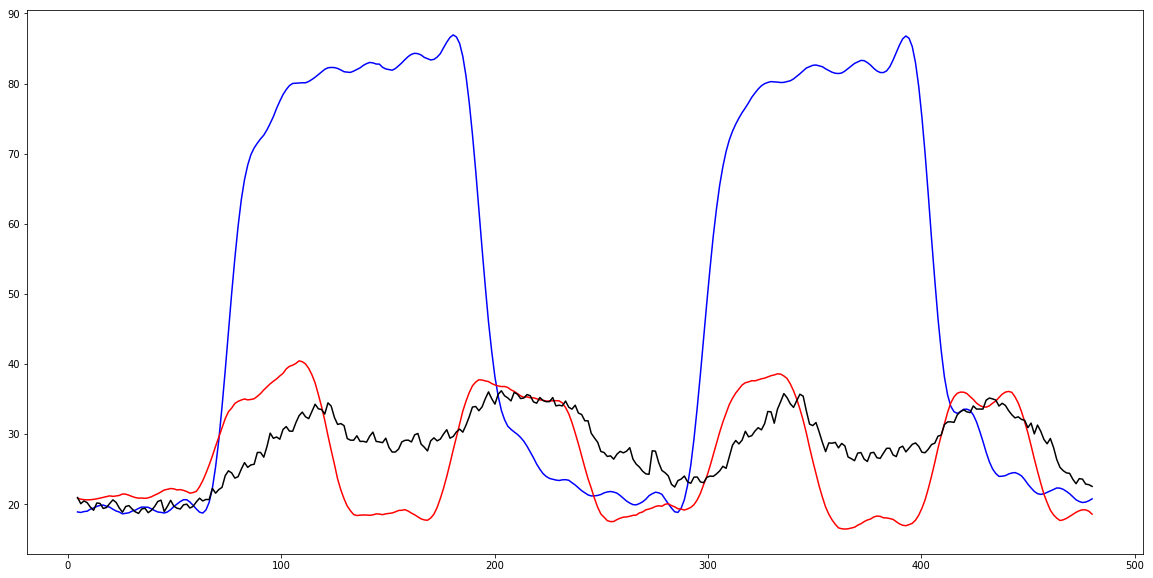

In [11]:
plt.figure(figsize=(20,10))
plt.plot(meants_ts, O2_exact_aligned, color='blue')
plt.plot(meants_ts, sg.savgol_filter(CO2_exact_aligned,21,3), color='red')
plt.plot(meants_ts, meants, color='black')



In [12]:
def get_cost(C1, C2, C3, sig1, sig2, composite_sig):
    """
    mean squared error for a linear combination of 2 independent signals
    
    C1 = constant for sig1
    C2 = constant for sig2
    sig1 = signal 1
    sig2 = signal 2 
    composite_sig = observed additive combination of sig1 and sig2
    """
    if((len(sig1) + len(sig2) + len(composite_sig))/len(sig1) != 3):
        print("ERROR: signals are not the same length")
        return np.nan
    else:
        return(np.sum((C1*sig1 + C2*sig2 + C3 - composite_sig)**2)/len(sig1))

In [13]:
#construct cost array
cost_dict = {'C1' : [], 'C2' : [], 'Cost' : []}
for c1 in np.arange(.075,.2,.0001):
    for c2 in np.arange(.25,.5,.0001):
        cost_dict['C1'].append(c1)
        cost_dict['C2'].append(c2)
        cost_dict['Cost'].append(get_cost(c1,c2, 9,O2_exact_aligned, CO2_exact_aligned, meants))
cost_df = pd.DataFrame(cost_dict)
print(cost_df.head())

      C1      C2       Cost
0  0.075  0.2500  92.664949
1  0.075  0.2501  92.616970
2  0.075  0.2502  92.569007
3  0.075  0.2503  92.521058
4  0.075  0.2504  92.473125


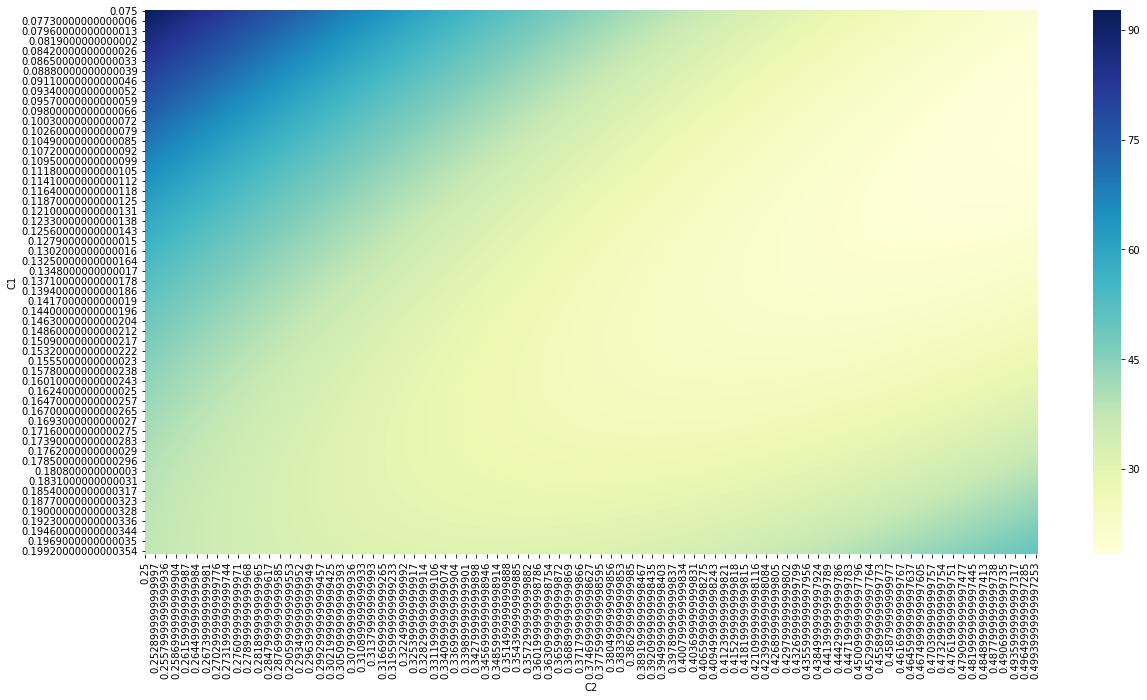

In [14]:
sns_pivot = cost_df.pivot('C1','C2','Cost')
plt.figure(figsize=(20,10))
sns.heatmap(sns_pivot, cmap="YlGnBu")

# Generating General Linear Model

In [15]:
def grad_constant(c1,c2,c3,s1n, s2n, bn):
    return(2*(c1*s1n + c2*s2n + c3 - bn))
def grad_C1(C1, C2, C3, S1, S2, B):
    buffer = 0.0
#     print("______________________________________________________________________________")
    for s1n, s2n, bn in zip(S1, S2, B):
        buffer += grad_constant(C1, C2, C3, s1n, s2n, bn) * s1n/len(S1)
#         print(buffer)
    return buffer

def grad_C2(C1, C2, C3, S1, S2, B):
    buffer = 0.0
    for s1n, s2n, bn in zip(S1, S2, B):
        buffer += grad_constant(C1, C2, C3, s1n, s2n, bn) * s2n/len(S1)
    return buffer

def grad_C3(C1, C2, C3, S1, S2, B):
    buffer = 0.0
    for s1n, s2n, bn in zip(S1, S2, B):
        buffer += grad_constant(C1, C2, C3, s1n, s2n, bn)/len(S1)
    return buffer

def linear_optimize(S1, S2, B, init_tuple=(0,0,0), descent_speed=.1, lifespan = 100, p_factor = .9):
    factor1 = np.max(S1)
    factor2 = np.max(S2)
    factorB = np.max(B)
    
    S1 = S1/factor1
    S2 = S2/factor2
    B = B/factorB
    
    curr_C1 = init_tuple[0]*factor1/factorB
    curr_C2 = init_tuple[1]*factor2/factorB
    curr_C3 = init_tuple[2]/factorB
    
#     curr_C1 = init_tuple[0]
#     curr_C2 = init_tuple[1]
#     curr_C3 = init_tuple[2]

    pC1 = 0.0
    pC2 = 0.0
    pC3 = 0.0
    
    for i in tqdm(range(lifespan)):
        pC1 = p_factor*pC1 + (1.0-p_factor)*grad_C1(curr_C1, curr_C2, curr_C3, S1, S2, B)
        pC2 = p_factor*pC2 + (1.0-p_factor)*grad_C2(curr_C1, curr_C2, curr_C3, S1, S2, B)
        pC3 = p_factor*pC3 + (1.0-p_factor)*grad_C3(curr_C1, curr_C2, curr_C3, S1, S2, B)
        
        curr_C1 = curr_C1 - (descent_speed* pC1)
        curr_C2 = curr_C2 - (descent_speed* pC2)
        curr_C3 = curr_C3 - (descent_speed* pC3)
        
        
    return_tuple = (curr_C1*factorB/factor1, curr_C2*factorB/factor2, curr_C3*factorB)
#     return_tuple = (curr_C1, curr_C2, curr_C3)
    S1 = S1*factor1
    S2 = S2*factor2
    B = B*factorB
    return return_tuple

In [16]:
#create cubic nodes
nodes = [(.5,.5,.5)]
surface_list = [0,.25,.5,.75,1]
for i in surface_list:
    for j in surface_list:
        for k in surface_list:
            nodes.append((i,j,k))

In [17]:
predicted_coeffs_90 = linear_optimize(O2_exact_aligned, CO2_exact_aligned, meants, lifespan=500, p_factor = .9)
predicted_coeffs_50 = linear_optimize(O2_exact_aligned, CO2_exact_aligned, meants, lifespan=500, p_factor = .5)
predicted_coeffs_98 = linear_optimize(O2_exact_aligned, CO2_exact_aligned, meants, lifespan=500, p_factor = .98)

100%|██████████| 500/500 [00:01<00:00, 321.97it/s]


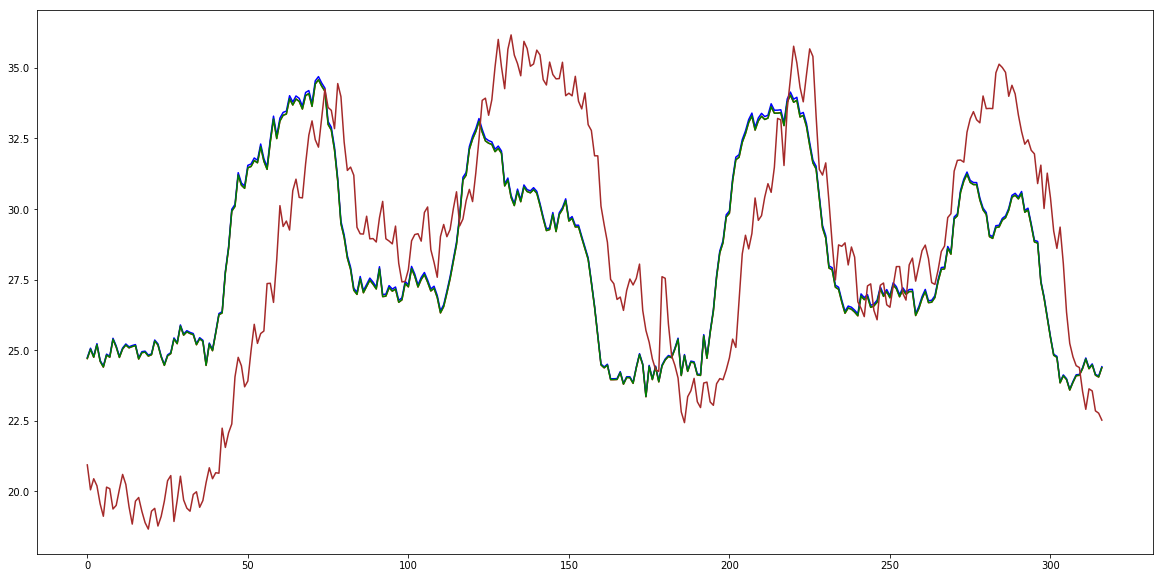

In [18]:
predicted_meants_90 = predicted_coeffs_90[0]*O2_exact_aligned + predicted_coeffs_90[1]*CO2_exact_aligned +predicted_coeffs_90[2]
predicted_meants_98 = predicted_coeffs_98[0]*O2_exact_aligned + predicted_coeffs_98[1]*CO2_exact_aligned +predicted_coeffs_98[2]
predicted_meants_50 = predicted_coeffs_50[0]*O2_exact_aligned + predicted_coeffs_50[1]*CO2_exact_aligned +predicted_coeffs_50[2]
plt.figure(figsize=(20,10))
plt.plot(predicted_meants_90, color='red')
plt.plot(predicted_meants_98, color='blue')
plt.plot(predicted_meants_50, color='green')
plt.plot(meants, color = 'brown')

# Correlation and Convolution

In [19]:
#resample data (w.r.t. time)

O2_downsampler = interp.interp1d(data.Time, filtered_O2, fill_value = 'extrapolate')
CO2_downsampler = interp.interp1d(data.Time, filtered_CO2, fill_value = 'extrapolate')

O2_unaligned_resample = O2_downsampler(meants_ts)
CO2_unaligned_resample = CO2_downsampler(meants_ts)

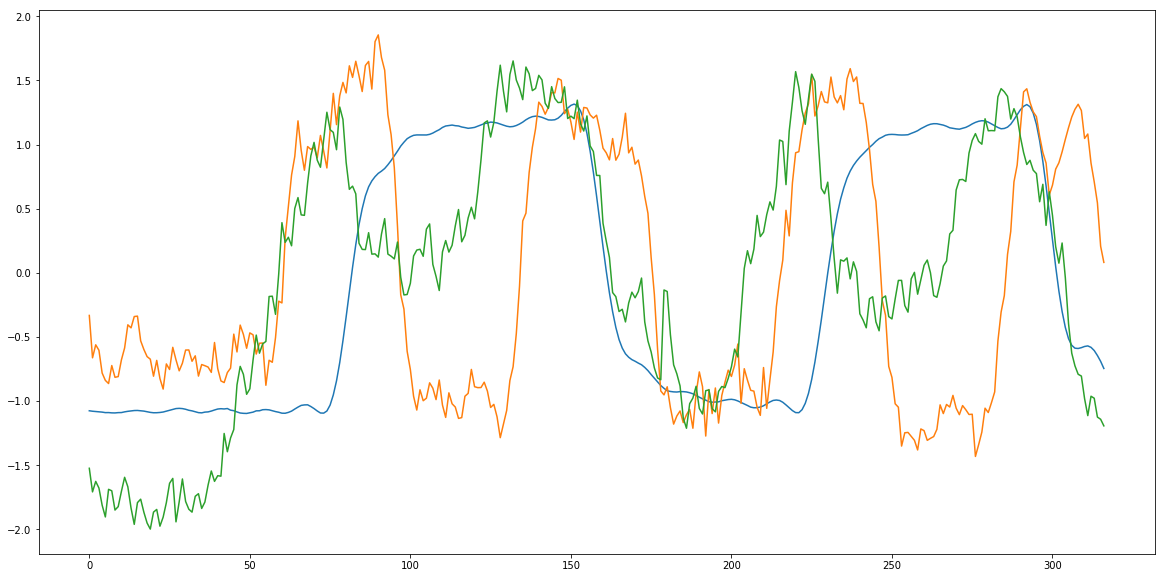

In [20]:
#normalize data
O2_unaligned_resample_demeaned = O2_unaligned_resample - O2_unaligned_resample.mean()
O2_unaligned_resample_norm = O2_unaligned_resample_demeaned/O2_unaligned_resample_demeaned.std()

CO2_unaligned_resample_demeaned = CO2_unaligned_resample - CO2_unaligned_resample.mean()
CO2_unaligned_resample_norm = CO2_unaligned_resample_demeaned/CO2_unaligned_resample_demeaned.std()

meants_demeaned = meants - meants.mean()
meants_norm = meants_demeaned/meants_demeaned.std()

plt.figure(figsize=(20,10))
plt.plot(O2_unaligned_resample_norm)
plt.plot(CO2_unaligned_resample_norm)
plt.plot(meants_norm)

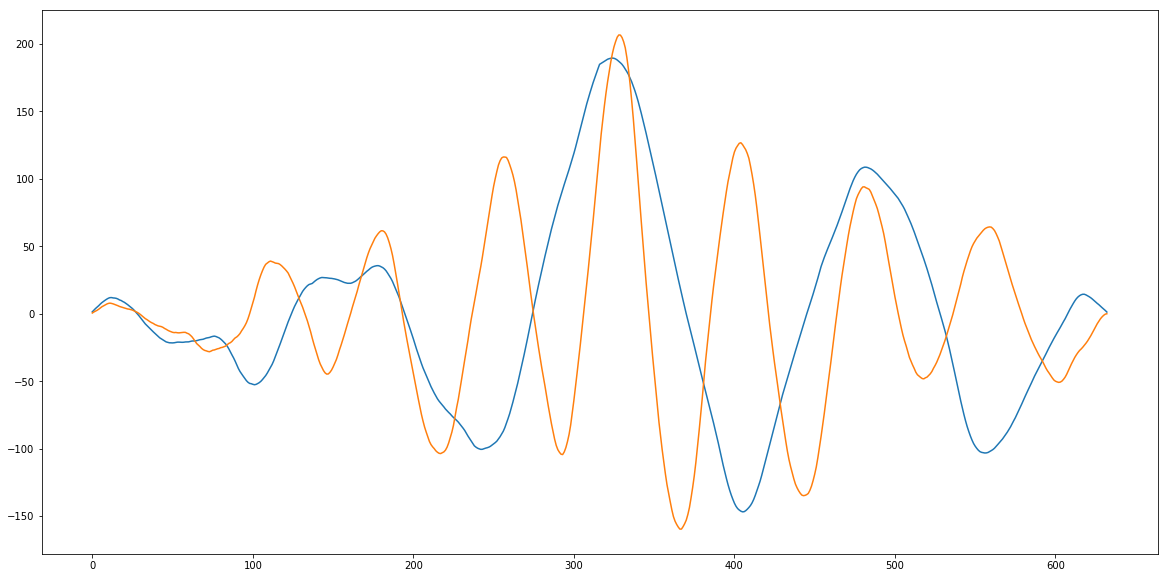

In [21]:
#calculate correlations
O2_correlation = sg.correlate(O2_unaligned_resample_norm, meants_norm)
CO2_correlation = sg.correlate(CO2_unaligned_resample_norm, meants_norm)

plt.figure(figsize=(20,10))
plt.plot(O2_correlation)
plt.plot(CO2_correlation)

In [22]:
#get argmax of correlation and convert to time
O2_correlation_shift = (O2_correlation.argmax() - (len(O2_correlation)//2))*480/len(meants_ts)
CO2_correlation_shift = (CO2_correlation.argmax() - (len(O2_correlation)//2))*480/len(meants_ts)

print("(O2, CO2): ", O2_correlation_shift, CO2_correlation_shift)


(O2, CO2):  12.113564668769715 18.170347003154575


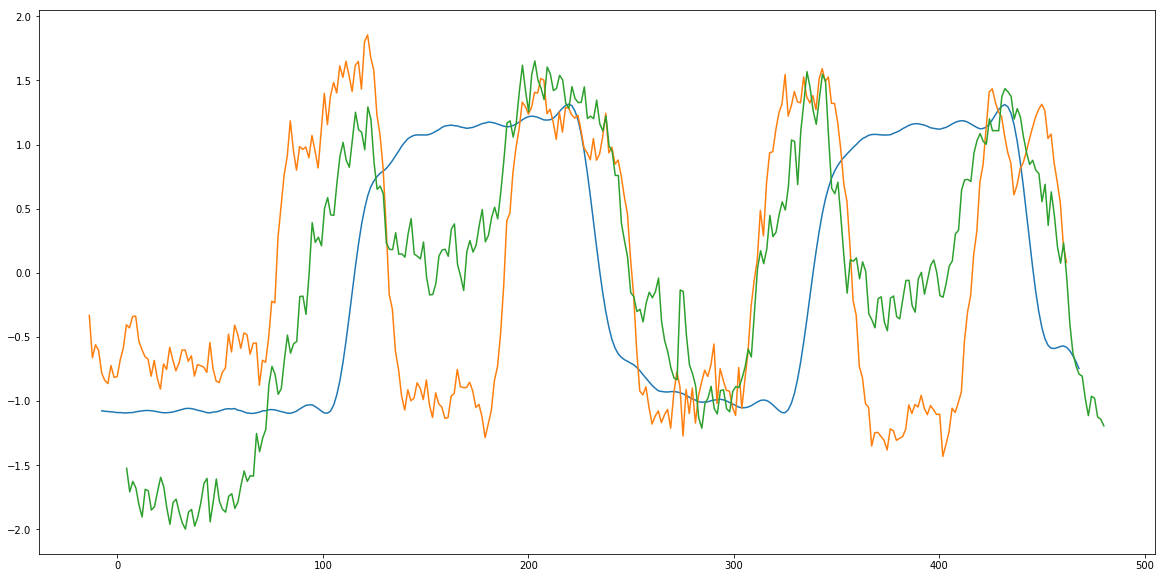

In [23]:
#check fit
plt.figure(figsize=(20,10))
plt.plot(meants_ts-O2_correlation_shift, O2_unaligned_resample_norm)
plt.plot(meants_ts-CO2_correlation_shift, CO2_unaligned_resample_norm)
plt.plot(meants_ts, meants_norm)

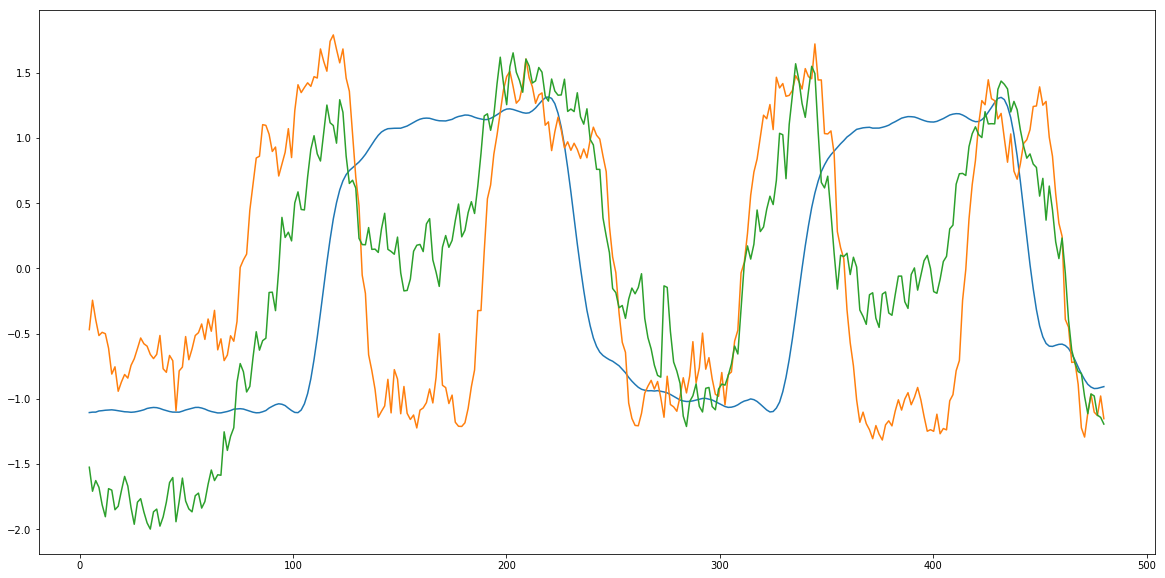

In [24]:
#create high-dim resamplers accounting for shifts and resample
O2_aligned_downsampler = interp.interp1d(data.Time-O2_correlation_shift, filtered_O2, fill_value = 'extrapolate')
CO2_aligned_downsampler = interp.interp1d(data.Time-CO2_correlation_shift, filtered_CO2, fill_value = 'extrapolate')

O2_correlation_aligned = O2_aligned_downsampler(meants_ts)
CO2_correlation_aligned = CO2_aligned_downsampler(meants_ts)

#demean new data
O2_correlation_aligned -= O2_correlation_aligned.mean()
O2_correlation_aligned /= O2_correlation_aligned.std()
CO2_correlation_aligned -= CO2_correlation_aligned.mean()
CO2_correlation_aligned /= CO2_correlation_aligned.std()

#check
plt.figure(figsize=(20,10))
plt.plot(meants_ts, O2_correlation_aligned)
plt.plot(meants_ts, CO2_correlation_aligned)
plt.plot(meants_ts, meants_norm)

In [25]:
O2_phase_fit_correlation = np.sum(sg.savgol_filter(O2_correlation_aligned,21,3)*meants_norm)
O2_phase_fit_centroid = np.sum(sg.savgol_filter(O2_exact_aligned_review,21,3)*meants_norm)

CO2_phase_fit_correlation = np.sum(sg.savgol_filter(CO2_correlation_aligned,21,3)*meants_norm)
CO2_phase_fit_centroid = np.sum(sg.savgol_filter(CO2_exact_aligned_review,21,3)*meants_review)

print(O2_phase_fit_correlation, O2_phase_fit_centroid, CO2_phase_fit_correlation, CO2_phase_fit_centroid)

197.38563061856297 105.32251355086845 213.96634307248752 185.5872898750599


# GLM of Cross Correlation

In [26]:
#get coefficients
predicted_coeffs_correlation = analysis.optimizer().stochastic_optimize_GLM(O2_correlation_aligned, CO2_correlation_aligned, meants_norm, lifespan = 1000)

100%|██████████| 1000/1000 [00:01<00:00, 509.67it/s]


In [32]:
predicted_response_correlation = predicted_coeffs_correlation[0]*O2_correlation_aligned + predicted_coeffs_correlation[1] * CO2_correlation_aligned + predicted_coeffs_correlation[2]
print(predicted_coeffs_correlation)

(0.5880712472098791, 0.6443654586762759, 1.1913160102252306e-15)


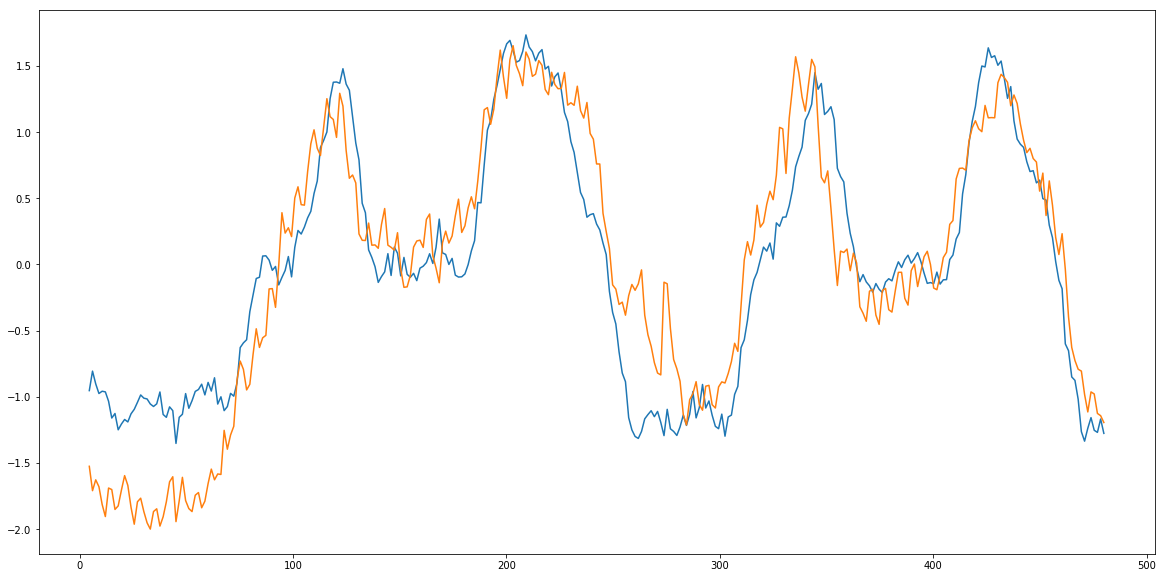

In [28]:
#check fit
plt.figure(figsize=(20,10))
plt.plot(meants_ts, predicted_response_correlation)
plt.plot(meants_ts, meants_norm)

In [31]:
print(analysis.stat_utils.get_r2(predicted_response_correlation, meants_norm))

0.7545831895100773
